In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *

%matplotlib inline 

In [2]:
NB_NODES = 50
DURATION = 10000   # Nb samples
REVOLUTION = 1800  # Nb samples
SAMPLE_FREQ = 0.1  # Hz, 1 sample every 10 seconds
CONNECTION_RANGE = 30000 # m

# Variables globales figures
TMAX = REVOLUTION/SAMPLE_FREQ
IDX = np.arange(0, TMAX, 1/SAMPLE_FREQ) # conversion en secondes

In [3]:
PATH = '..\..\data\cnes_swarm50\\track_'
satellites = {}

with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df = pd.read_csv(PATH+str(i)+'.csv')
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)

satellites[0]

Extracting data: 100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.428846e+05,-4.516533e+05,-4.604007e+05,-4.691266e+05,-4.778306e+05,-4.865122e+05,-4.951711e+05,-5.038068e+05,-5.124189e+05,-5.210071e+05,...,1.440812e+06,1.444147e+06,1.447475e+06,1.450795e+06,1.454108e+06,1.457413e+06,1.460711e+06,1.464001e+06,1.467284e+06,1.470559e+06
y,-7.388676e+05,-7.522884e+05,-7.656739e+05,-7.790237e+05,-7.923370e+05,-8.056132e+05,-8.188518e+05,-8.320520e+05,-8.452134e+05,-8.583352e+05,...,2.329204e+06,2.334225e+06,2.339233e+06,2.344229e+06,2.349213e+06,2.354185e+06,2.359145e+06,2.364092e+06,2.369028e+06,2.373951e+06
z,-2.011435e+06,-2.004528e+06,-1.997528e+06,-1.990435e+06,-1.983248e+06,-1.975968e+06,-1.968596e+06,-1.961132e+06,-1.953577e+06,-1.945930e+06,...,3.661057e+06,3.655167e+06,3.649258e+06,3.643331e+06,3.637384e+06,3.631419e+06,3.625435e+06,3.619433e+06,3.613412e+06,3.607372e+06


In [34]:
swarm_data = {}

with tqdm(total = REVOLUTION, desc = 'Converting to Swarm') as pbar:
    for t in range(REVOLUTION):
        swarm_data[t] = Swarm(
            connection_range=CONNECTION_RANGE, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
            )
        pbar.update(1)

print(swarm_data[0])

Converting to Swarm: 100%|██████████| 1800/1800 [00:02<00:00, 720.17it/s]

Swarm of 50 node(s), connection range: 30000


In [35]:
swarm = swarm_data[0]

In [36]:
nmat = swarm.neighbor_matrix()
nmat[0]

[0,
 1,
 0,
 0,
 4,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 1,
 0,
 1,
 4,
 1,
 4,
 1,
 4,
 4,
 1,
 4,
 0,
 1,
 4,
 4,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 1,
 4,
 1,
 1,
 4,
 0,
 0,
 4,
 0]

In [47]:
len(swarm.nodes[0].neighbors)

15

In [38]:
iso = swarm.isolated_nodes()
for n in iso:
    print(n)

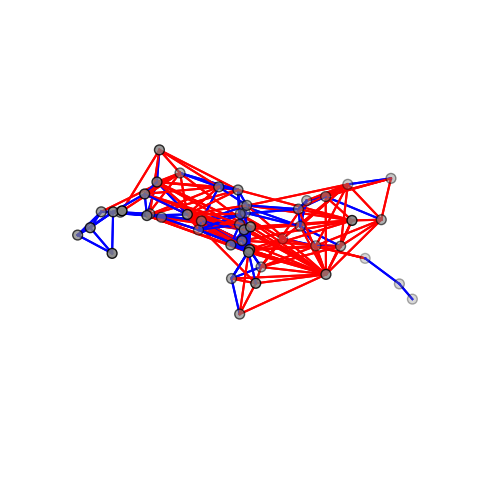

In [45]:
def plot_edges(swarm, n_color='gray'):
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    x_data = [node.x for node in swarm.nodes]
    y_data = [node.y for node in swarm.nodes]
    z_data = [node.z for node in swarm.nodes]
    ax.scatter(x_data, y_data, z_data, c=n_color, edgecolor='black', s=50)
    edgecolors = {1:'blue', 4:'red'}
    for n1 in swarm.nodes:
        for nid,w in n1.neighbors.items():
            n2 = swarm.get_node_by_id(nid)
            ax.plot([n1.x, n2.x], [n1.y, n2.y], [n1.z, n2.z], c=edgecolors[w])
                
plot_edges(swarm)

In [40]:
def swarm_to_weighted_graph(swarm):
    G = nx.Graph()
    G.add_nodes_from([n.id for n in swarm.nodes])
    visited = []
    for node in swarm.nodes:
        n1 = node.id
        for n2, w in node.neighbors.items():
            if n1 != n2 and set((n1, n2)) not in visited:
                visited.append((n1,n2))
                G.add_edge(n1, n2, weight=w)
    return G

g = swarm_to_weighted_graph(swarm)
print(g)

Graph with 50 nodes and 485 edges


In [41]:
for n,w in swarm.nodes[0].neighbors.items():
    print('ISL weight:', w, 'SPL:', nx.shortest_path_length(g, 0, n, weight='weight'))

ISL weight: 1 SPL: 1
ISL weight: 4 SPL: 4
ISL weight: 4 SPL: 3
ISL weight: 4 SPL: 3
ISL weight: 1 SPL: 1
ISL weight: 1 SPL: 1
ISL weight: 4 SPL: 2
ISL weight: 1 SPL: 1
ISL weight: 4 SPL: 2
ISL weight: 1 SPL: 1
ISL weight: 4 SPL: 3
ISL weight: 4 SPL: 2
ISL weight: 1 SPL: 1
ISL weight: 4 SPL: 2
ISL weight: 1 SPL: 1
ISL weight: 4 SPL: 2
ISL weight: 4 SPL: 2
ISL weight: 4 SPL: 4
ISL weight: 4 SPL: 4
ISL weight: 4 SPL: 2
ISL weight: 4 SPL: 2
ISL weight: 4 SPL: 4
ISL weight: 4 SPL: 4
ISL weight: 4 SPL: 2
ISL weight: 1 SPL: 1
ISL weight: 4 SPL: 3
ISL weight: 1 SPL: 1
ISL weight: 1 SPL: 1
ISL weight: 4 SPL: 2
ISL weight: 4 SPL: 2


In [42]:
for node in swarm.nodes:
    n1 = node.id
    ncopy = dict(node.neighbors)
    for n2,w in ncopy.items():
        if nx.shortest_path_length(g, n1, n2, weight='weight') < w:
            node.remove_neighbor(n2)

In [43]:
for n,w in swarm.nodes[0].neighbors.items():
    print('ISL weight:', w, 'SPL:', nx.shortest_path_length(g, 0, n, weight='weight'))

ISL weight: 1 SPL: 1
ISL weight: 4 SPL: 4
ISL weight: 1 SPL: 1
ISL weight: 1 SPL: 1
ISL weight: 1 SPL: 1
ISL weight: 1 SPL: 1
ISL weight: 1 SPL: 1
ISL weight: 1 SPL: 1
ISL weight: 4 SPL: 4
ISL weight: 4 SPL: 4
ISL weight: 4 SPL: 4
ISL weight: 4 SPL: 4
ISL weight: 1 SPL: 1
ISL weight: 1 SPL: 1
ISL weight: 1 SPL: 1


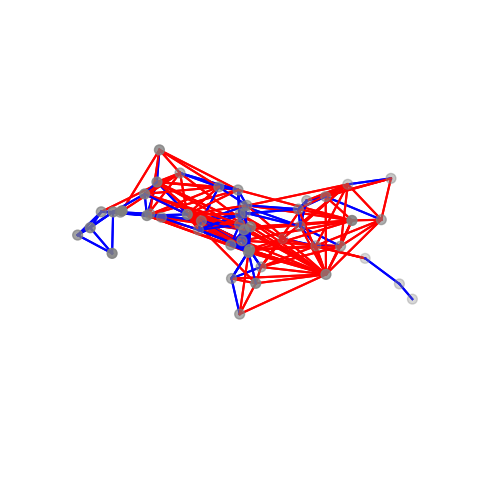

In [44]:
plot_edges(swarm)